<a href="https://colab.research.google.com/github/Esther-Velasco/Bike-Sharing-Demand-Forecast-in-London/blob/main/Final_London_cycling_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns

In [ ]:
arima_data = pd.read_csv("https://raw.githubusercontent.com/Esther-Velasco/esther_labs/main/Final%20Project/sharing_data_refined.csv")
arima_data

,Unnamed: 0,daily_count,real_temperature,felt_temperature,humidity,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04,9234.0,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0
1,2015-01-05,20372.0,193.0,161.0,1927.5,212.5,80.0,0.0,0.0,72.0
2,2015-01-06,20613.0,188.5,128.0,1893.5,384.0,74.0,0.0,0.0,72.0
3,2015-01-07,21064.0,171.5,103.5,1796.5,454.5,60.0,0.0,0.0,69.0
4,2015-01-08,15601.0,234.0,187.0,1903.5,491.5,84.0,0.0,0.0,72.0
...,...,...,...,...,...,...,...,...,...,...
726,2016-12-30,11566.0,78.5,25.5,2368.5,216.0,105.0,0.0,0.0,72.0
727,2016-12-31,11424.0,178.5,121.0,2183.0,319.5,98.0,0.0,24.0,72.0
728,2017-01-01,6421.0,168.0,106.5,2122.5,339.0,150.0,0.0,24.0,72.0
729,2017-01-02,11823.0,89.5,22.5,1995.5,268.0,29.0,24.0,0.0,72.0


In [ ]:
#Since I am working with time-series data:
#converting to a pandas day-time object and setting the index in the date-time for the time series analysis
arima_data["timestamp"] = pd.to_datetime(arima_data["Unnamed: 0"])
arima_data = arima_data.set_index("timestamp")


In [ ]:
arima_data = arima_data.resample('D').sum()
arima_data.head()

<ipython-input-5-22d2581bd9ef>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  arima_data = arima_data.resample('D').sum()


,daily_count,real_temperature,felt_temperature,humidity,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04,9234.0,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0
2015-01-05,20372.0,193.0,161.0,1927.5,212.5,80.0,0.0,0.0,72.0
2015-01-06,20613.0,188.5,128.0,1893.5,384.0,74.0,0.0,0.0,72.0
2015-01-07,21064.0,171.5,103.5,1796.5,454.5,60.0,0.0,0.0,69.0
2015-01-08,15601.0,234.0,187.0,1903.5,491.5,84.0,0.0,0.0,72.0


In [ ]:
#!pip install pmdarima

# Plot the data to understand trend

<Axes: xlabel='timestamp'>

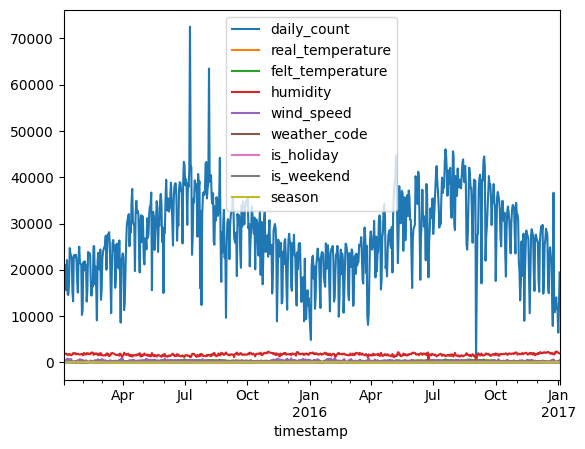

In [ ]:
arima_data.plot()

**What is ARIMA?**


ARIMA is a general class of statistical models for time series analysis forecasting (general, because for different time-series, we will be able to fit them with different combinations of the 3 parameters of ARIMA).

ARIMA uses a time series past values or/and forecast errors to predict future values.

Main assumption is that the time series presents stationary data : statistical properties remain constant across time.

In [ ]:
msk = (arima_data.index < arima_data.index[-365])
df_train = arima_data[msk].copy()
df_test = arima_data[~msk].copy()

# Step 1: Check for stationarity
You can check stationarity with the Autocorrelation Function (ACF) plot. If ACF decreases quickly, it suggests stationarity; a slow decline indicates non-stationarity. In this case, the data shows a very slow decline therefore being non-stationary.

Other methods : time-series plot (above), but when it is not clearly visible, also one can use PACF Plot, ADF Test (done below)



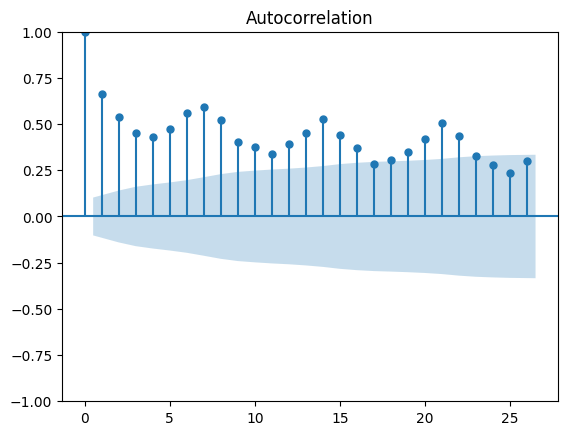

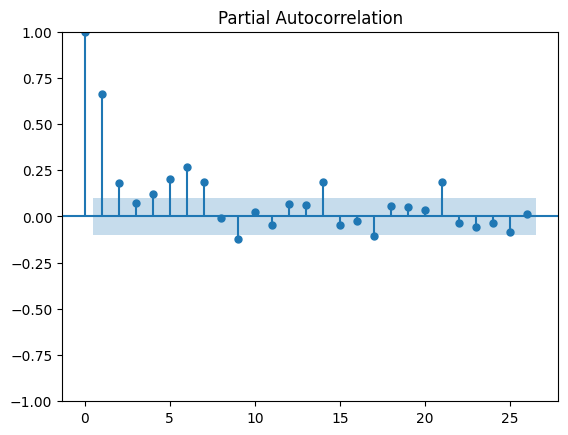

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df_train["daily_count"])
pacf_original = plot_pacf(df_train["daily_count"])

A time series is stationary when its mean, variance and auto-correlation, etc., are constant over time. Many time-series methods may perform better when a time-series is stationary, since forecasting values becomes a far easier task for a stationary time series. ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling. If the plot does not appear relatively stationary, your model will likely need a differencing term. These can be determined by using an Augmented Dickey-Fuller test, or various other statistical testing methods. Note that auto_arima will automatically determine the appropriate differencing term for you by default.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train["daily_count"])
print(f'p-value: {adf_test[1]}')

p-value: 0.7359879968821779


In [ ]:
#pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_train["daily_count"])
p_val, should_diff # True : differenciation needed.

(0.7531247618363114, True)

The easiest way to make your data stationary in the case of ARIMA models is to allow auto_arima to work its magic, estimate the appropriate d value, and difference the time series accordingly.

The auto_arima function fits the best ARIMA model to a univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

Three main components/parameters (non-negative integer values):

> **AR + I + MA (p,d,q)**

> AR (Auto-Regressive): time series is linearly regressed on its own past values.
- p = the number of past values included in the AR Model.

> I (Integrated): if NOT stationary - the case here - the time series can be differenced to become stationary, i.e., computing the differences between consecutive observations.
- d = the number of times the time sereis is differenced

> MA (Moving Average): time series is "regressed" on the past forecast errors.
- q = the number of past forecast errors included in the MA model.

**(p,d,q) order, refers to the order of the time series. This order is also used in the ARIMA model (which does not consider seasonality);**








# Transform to stationary differencing

<Axes: xlabel='timestamp'>

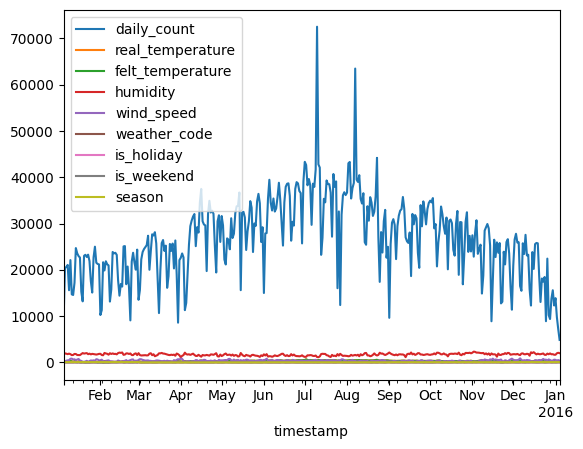

In [ ]:
df_train_diff = df_train.shift(1).dropna() # forecasting value with -1 past value
df_train_diff.plot()

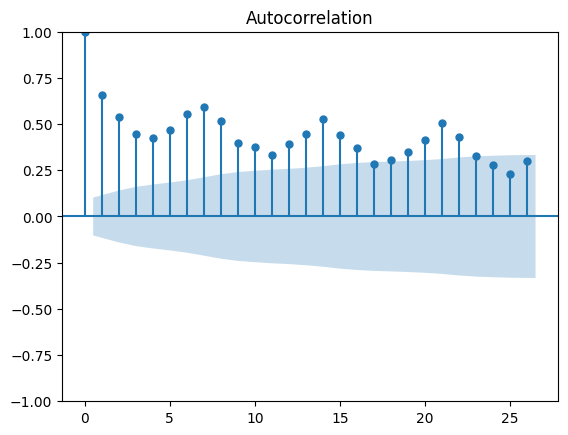

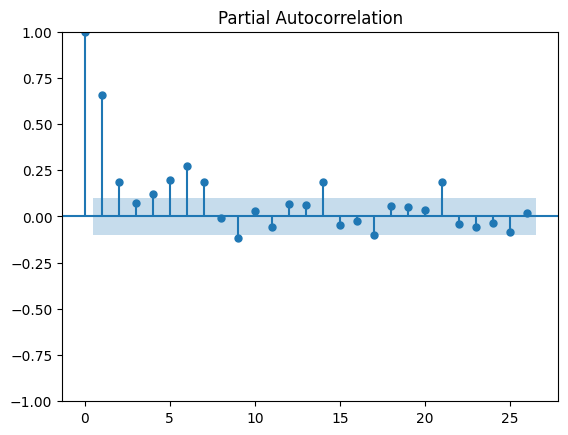

In [ ]:
acf_diff = plot_acf(df_train_diff["daily_count"])

pacf_diff = plot_pacf(df_train_diff["daily_count"])

In [ ]:
# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_train_diff["daily_count"])
p_val, should_diff # True : differenciation needed.

(0.8672204471094704, True)

In [ ]:
adf_test = adfuller(df_train_diff["daily_count"])
print(f'p-value: {adf_test[1]}')

p-value: 0.797437693786848


<Axes: xlabel='timestamp'>

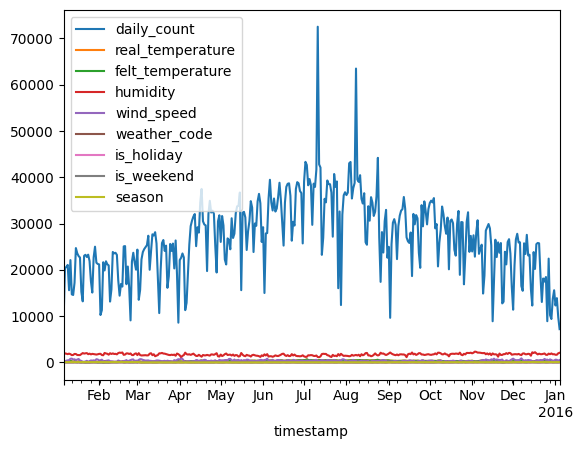

In [ ]:
# second degree differencing (Max RECOMMENDED)
df_train_2diff = df_train_diff.shift(1).dropna() # forecasting value with -1 past value
df_train_2diff.plot()

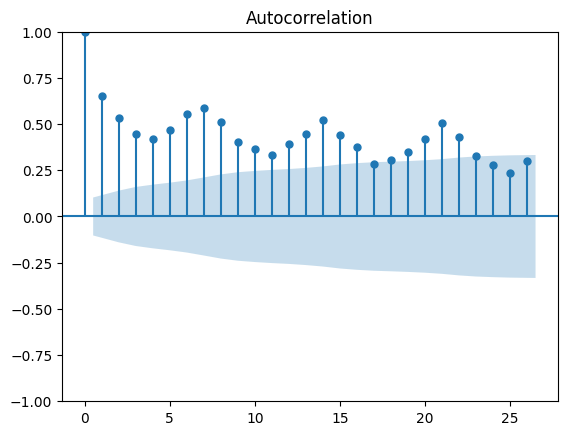

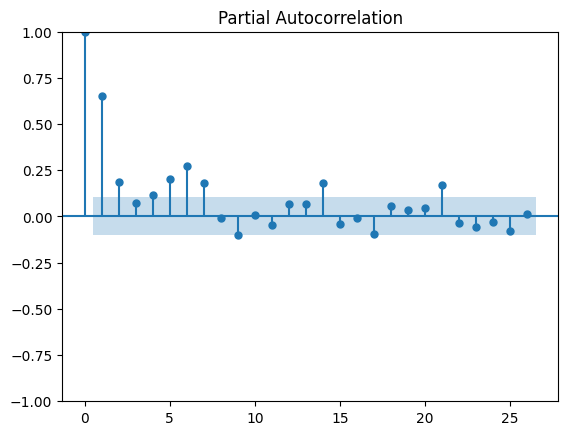

In [ ]:
acf_diff = plot_acf(df_train_2diff["daily_count"])

pacf_diff = plot_pacf(df_train_2diff["daily_count"])

In [ ]:
# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_train_2diff["daily_count"])
p_val, should_diff # Still True : differenciation needed.

(0.8173400781632999, True)

# Step 2: Determine parameters p, q:

Rule of thumb to select the values of p and q:
- If PACF Plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually. This may suggest an ARIMA (p,d,0) model.

- If the ACF plot has a significant spike at lag q, but not beyond; the PACF plot decays more gradually. This may suggest an ARIMA (0, d, q) model.

Here PACF shows more spikes and ACF a more gradual decay suggesting an ARIMA (p,d,0) model.

With this results we should try and plot:
- (2,1,0)
- (3,1,0)
- (4,1,0)
- (5,1,0)

# Fit ARIMA Model


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train["daily_count"], order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            daily_count   No. Observations:                  366
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3684.669
Date:                Tue, 12 Dec 2023   AIC                           7381.338
Time:                        10:04:35   BIC                           7404.737
Sample:                    01-04-2015   HQIC                          7390.637
                         - 01-04-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5439      0.044    -12.293      0.000      -0.631      -0.457
ar.L2         -0.4077      0.053     -7.644      0.000      -0.512      -0.303
ar.L3         -0.4073      0.050     -8.108      0.0

## Determine residuals
Now we can use this model to make predictions.
But first we need to make sure that it has captured all adequate information from the data. If the model is good, its residuals should look like white noise (look random, normal distribution density with mean around 0).

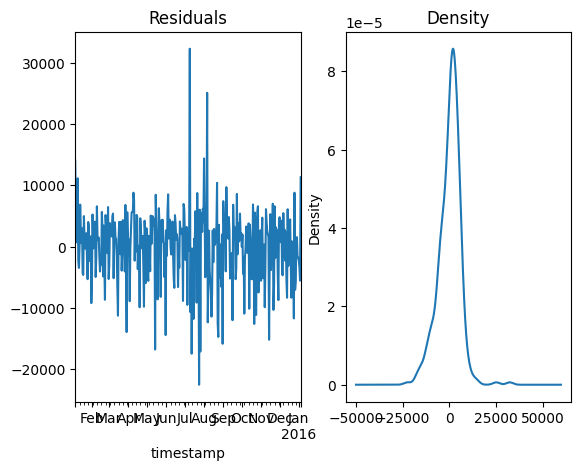

In [ ]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

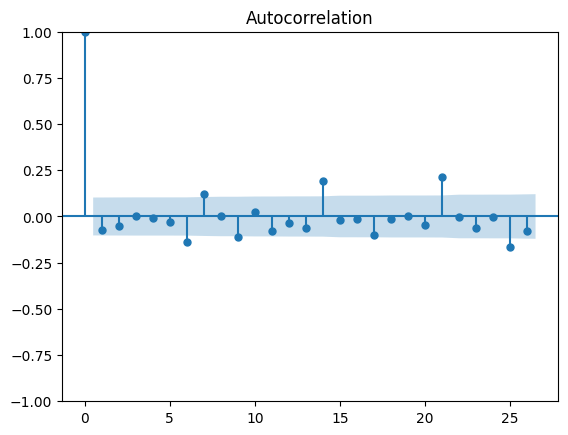

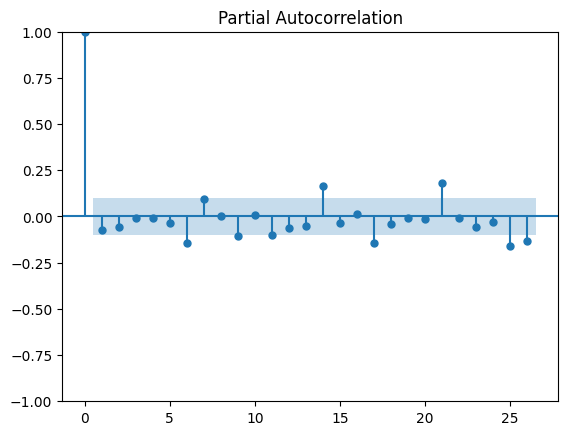

In [ ]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

# Step 3 : Making predictions

<Axes: xlabel='timestamp'>

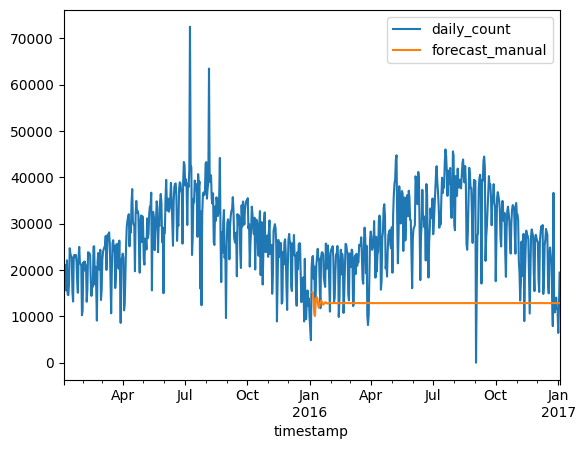

In [ ]:
forecast_test = model_fit.forecast(len(df_test))

arima_data['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

arima_data[["daily_count", "forecast_manual"]].plot()


# Step 4: using autoarima to auto-fit the model (parameter setting)

**Adding seasonal_order (Seasonal Order):**

The seasonal_order parameter specifies the orders of the seasonal components of the SARIMA model.
It is denoted as (P, D, Q, s), where:

- P represents the seasonal order of the Seasonal AutoRegressive (SAR) component, which captures the seasonal linear relationship between the current observation and its past values separated by a seasonal period s.
- D represents the seasonal order of differencing for seasonal stationarity.
- Q represents the seasonal order of the Seasonal Moving Average (SMA) component, which captures the seasonal linear relationship between the current observation and past white noise (residuals) separated by a seasonal period s.

In [ ]:
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

auto_arima = pm.auto_arima(df_train["daily_count"], stepwise= True, seasonal= True)
auto_arima

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [ ]:
"""
data_fit = auto_arima(df_train["daily_count"], start_p = 1, start_q = 1,
						max_p = 3, max_q = 3, m = 7, # daily data
						start_P = 0, seasonal = True,
						d = None, D = 1, trace = True,
						error_action ='ignore', # we don't want to know if an order does not work
						suppress_warnings = True, # we don't want convergence warnings
						stepwise = True)		 # set to stepwise

# To print the summary
data_fit.summary()
"""

'\ndata_fit = auto_arima(df_train["daily_count"], start_p = 1, start_q = 1, \n\t\t\t\t\t\tmax_p = 3, max_q = 3, m = 7, # daily data \n\t\t\t\t\t\tstart_P = 0, seasonal = True, \n\t\t\t\t\t\td = None, D = 1, trace = True, \n\t\t\t\t\t\terror_action =\'ignore\', # we don\'t want to know if an order does not work \n\t\t\t\t\t\tsuppress_warnings = True, # we don\'t want convergence warnings \n\t\t\t\t\t\tstepwise = True)\t\t # set to stepwise \n\n# To print the summary \ndata_fit.summary()\n'

In [ ]:
"""

train, test = arima_data["daily_count"][:365], arima_data["daily_count"][365:]

# Fit different ARIMAs
m7 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=7, stepwise = True)
m52 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=52, stepwise = True)
m12 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=12, stepwise = True)
m1 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=1, stepwise = True)
"""


'\n\ntrain, test = arima_data["daily_count"][:365], arima_data["daily_count"][365:]\n\n# Fit different ARIMAs\nm7 = pm.auto_arima(train, error_action=\'ignore\', seasonal=True, m=7, stepwise = True)\nm52 = pm.auto_arima(train, error_action=\'ignore\', seasonal=True, m=52, stepwise = True)\nm12 = pm.auto_arima(train, error_action=\'ignore\', seasonal=True, m=12, stepwise = True)\nm1 = pm.auto_arima(train, error_action=\'ignore\', seasonal=True, m=1, stepwise = True)\n'

In [ ]:
"""
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
x = np.arange(test.shape[0])

# Plot m=7
axes[0].scatter(x, test, marker='x')
axes[0].plot(x, m7.predict(n_periods=test.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=7)')

# Plot m=12
axes[1].scatter(x, test, marker='x')
axes[1].plot(x, m12.predict(n_periods=test.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=12)')

# Plot m=52
axes[1].scatter(x, test, marker='x')
axes[1].plot(x, m52.predict(n_periods=test.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=52)')

# Plot m=1
axes[0].scatter(x, test, marker='x')
axes[0].plot(x, m1.predict(n_periods=test.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=1)')


plt.show()
"""

"\nfig, axes = plt.subplots(1, 2, figsize=(12, 8))\nx = np.arange(test.shape[0])\n\n# Plot m=7\naxes[0].scatter(x, test, marker='x')\naxes[0].plot(x, m7.predict(n_periods=test.shape[0]))\naxes[0].set_title('Test samples vs. forecasts (m=7)')\n\n# Plot m=12\naxes[1].scatter(x, test, marker='x')\naxes[1].plot(x, m12.predict(n_periods=test.shape[0]))\naxes[1].set_title('Test samples vs. forecasts (m=12)')\n\n# Plot m=52\naxes[1].scatter(x, test, marker='x')\naxes[1].plot(x, m52.predict(n_periods=test.shape[0]))\naxes[1].set_title('Test samples vs. forecasts (m=52)')\n\n# Plot m=1\naxes[0].scatter(x, test, marker='x')\naxes[0].plot(x, m1.predict(n_periods=test.shape[0]))\naxes[0].set_title('Test samples vs. forecasts (m=1)')\n\n\nplt.show()\n"

The autoprocess uses by default a:
1.   KPSS unit root test to determine --> d
2.   AIC information criteria --> p, q

Methods can be changed by setting them inside the functiona auto_arima.





In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -3662.395
Date:                Tue, 12 Dec 2023   AIC                           7338.790
Time:                        10:05:19   BIC                           7366.089
Sample:                    01-04-2015   HQIC                          7349.639
                         - 01-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -67.5815     56.311     -1.200      0.230    -177.949      42.785
ar.L1          1.2467      0.006    198.452      0.000       1.234       1.259
ar.L2         -0.9949      0.006   -172.258      0.000      -1.006      -0.984
ma.L1         -1.9674      0.045    -43.401      0.000      -2.056      -1.879
ma.L2          1.8648      0.065     28.630      0.000       1.737       1.992
ma.L3         -0.7243      0.046    -15.897      0.000      -0.814      -0.635
sigma2      3.282e+07   2.09e-05   1.57e+12      0.000    3.28e+07    3.28e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):               302.05
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.03
Prob(H) (two-sided):                  0.09   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+29. Standard errors may be unstable.
"""

At this stage we have two models:
- ARIMA (5,1,0)
- ARIMA SARIMAX(2,1,3)

# Step 5. Evaluate model predictions
Here we are not considering seasonality

<Axes: xlabel='timestamp'>

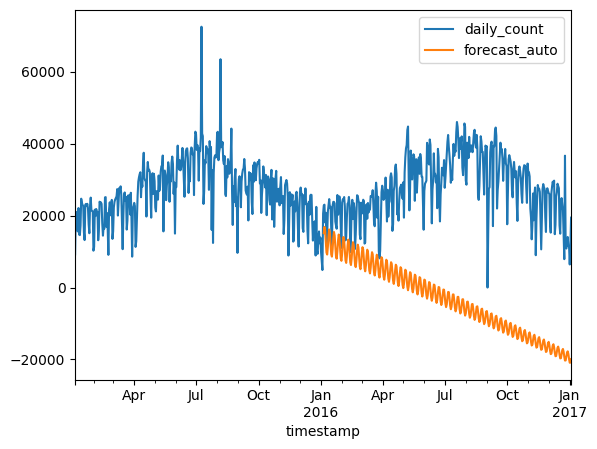

In [ ]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
arima_data['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)
arima_data[["daily_count", "forecast_auto"]].plot()

## Errors

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test["daily_count"], forecast_test)
mape = mean_absolute_percentage_error(df_test["daily_count"], forecast_test)
rmse = np.sqrt(mean_squared_error(df_test ["daily_count"], forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 15184.185011309703
mape - manual: 3525.7062183665553
rmse - manual: 17252.25976321899


In [ ]:
mae = mean_absolute_error(df_test["daily_count"], forecast_test_auto)
mape = mean_absolute_percentage_error(df_test["daily_count"], forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test["daily_count"], forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 30973.926239950088
mape - auto: 2152.0968698127585
rmse - auto: 33932.10216958599


It appears the model performs poorly.

# Step 6. Time series cross validation
## Cross Validation
For time series, we always predict into the future. However, in the above approach we will be training on data that is further in time than the evaluation test data. This is data leakage and should be avoided at all costs.

To overcome this problem, we need to ensure the test set always has a higher index (the index is usually time for time series data) than the training set. This means our test is always in the future compared to the data our model is fitted on.

In [ ]:
# Import packages " From Egor Howell Youtube chanel"
import plotly.graph_objects as go
import pandas as pd
from sklearn.model_selection import KFold


def plot_cross_val(n_splits: int,
                   splitter_func,
                   df: pd.DataFrame,
                   title_text: str) -> None:

    """Function to plot the cross validation of various
    sklearn splitter objects."""

    split = 1
    plot_data = []

    for train_index, valid_index in splitter_func(n_splits=n_splits).split(df):
        plot_data.append([train_index, 'Train', f'{split}'])
        plot_data.append([valid_index, 'Test', f'{split}'])
        split += 1

    plot_df = pd.DataFrame(plot_data,
                           columns=['Index', 'Dataset', 'Split'])\
                           .explode('Index')

    fig = go.Figure()
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                 y=group['Split'].loc[group['Dataset'] == 'Train'],
                                 name='Train',
                                 line=dict(color="blue", width=10)
                                 ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                 y=group['Split'].loc[group['Dataset'] == 'Test'],
                                 name='Test',
                                 line=dict(color="goldenrod", width=10)
                                 ))

    fig.update_layout(template="simple_white", font=dict(size=20),
                      title_text=title_text, title_x=0.5, width=850,
                      height=450, xaxis_title='Index', yaxis_title='Split')

    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))

    return fig.show()


In [ ]:
# Always make sure that test set is in the future as of the train test to avoid any kind of data leakage
#Import packages
from sklearn.model_selection import TimeSeriesSplit

# Plot the time series cross validation splits
plot_cross_val(n_splits=5,
               splitter_func=TimeSeriesSplit,
               df = arima_data,
               title_text='Time Series Cross-Validation')

## Hyperparameter tuning

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px



def hyperparameter_tuning_season_cv(n_splits: int,
                                    gammas: list[float],
                                    df: pd.DataFrame) -> pd.DataFrame:
    """Function to carry out cross-validation hyperparameter tuning
    for the seasonal parameter in a Holt Winters' model. """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    error_list = []

    for gamma in gammas:

        errors = []

        for train_index, valid_index in tscv.split(arima_data):
            train, valid = arima_data.iloc[train_index], arima_data.iloc[valid_index]

            model = ExponentialSmoothing(train['daily_count'], trend='mul',
                                         seasonal='mul', seasonal_periods=12) \
                .fit(smoothing_seasonal=gamma)

            forecasts = model.forecast(len(valid))
            errors.append(mean_absolute_percentage_error(valid['daily_count'], forecasts))

        error_list.append([gamma, sum(errors) / len(errors)])

    return pd.DataFrame(error_list, columns=['Gamma', 'MAPE'])


def plot_error_cv(df: pd.DataFrame,
                  title: str) -> None:
    """Bar chart to plot the errors from the different
    hyperparameters."""

    fig = px.bar(arima_data, x='Gamma', y='MAPE')
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=800, title_x=0.5, height=400)

    return fig.show()


In [ ]:
# Carry out cv for hyperparameter tuning for the seasonal parameter
error_df = hyperparameter_tuning_season_cv(df=arima_data["daily_count"],
                                         n_splits=4,
                                         gammas=list(np.arange(0, 1.1, 0.1)))
error_df


,Gamma,MAPE
0,0.0,9960.928500
1,0.1,7475.470428
2,0.2,7451.091102
3,0.3,7355.583499
4,0.4,7303.650471
5,0.5,7274.224612
6,0.6,7271.502588
7,0.7,7322.604380
8,0.8,7492.330972
9,0.9,7780.770210


It appears the optimal value of the smoothing_seasonal hyperparameter is 0.6 (lowest MAPE means lowest error).



In [ ]:
import statsmodels.api as sm

mod = sm.tsa.SARIMAX(arima_data[0:400].daily_count,
                    trend='n',
                    order=(5, 1, 0),
                    seasonal_order=(2, 1, 3, 365),
                    enforce_stationarity=True,
                    enforce_invertibility=False)
results = mod.fit()
print(results.summary())


# Step 7. Trying on weekly data.


In [ ]:
weekly_data = arima_data.resample('W').sum()
weekly_data.rename(columns={'daily_count': 'weekly_count'}, inplace=True)
weekly_data

,weekly_count,real_temperature,felt_temperature,humidity,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04,9234.0,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0
2015-01-11,129038.0,1503.5,1143.5,12526.5,3793.5,517.0,0.0,48.0,501.0
2015-01-18,139559.0,1153.0,695.0,12279.5,3464.0,624.0,0.0,48.0,504.0
2015-01-25,146866.0,577.0,142.0,13205.5,2003.0,435.0,0.0,48.0,504.0
2015-02-01,133247.0,899.0,238.0,12339.0,3656.0,691.0,0.0,48.0,504.0
...,...,...,...,...,...,...,...,...,...
2016-12-11,174112.0,1661.0,1541.5,14696.5,2095.0,402.0,0.0,48.0,504.0
2016-12-18,168680.0,1543.5,1384.5,15205.0,1509.5,525.0,0.0,48.0,504.0
2016-12-25,151948.0,1522.5,1276.5,13711.0,2935.0,491.0,0.0,48.0,504.0


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Train the model on the full dataset
model = SARIMAX(weekly_data["weekly_count"],
                        order = (3, 1, 3),
                        seasonal_order =(2, 1, 1, 52))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(weekly_data),
                          end = (len(weekly_data)-1) + 10 * 52,
                          typ = 'levels').rename('Forecast')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/loc

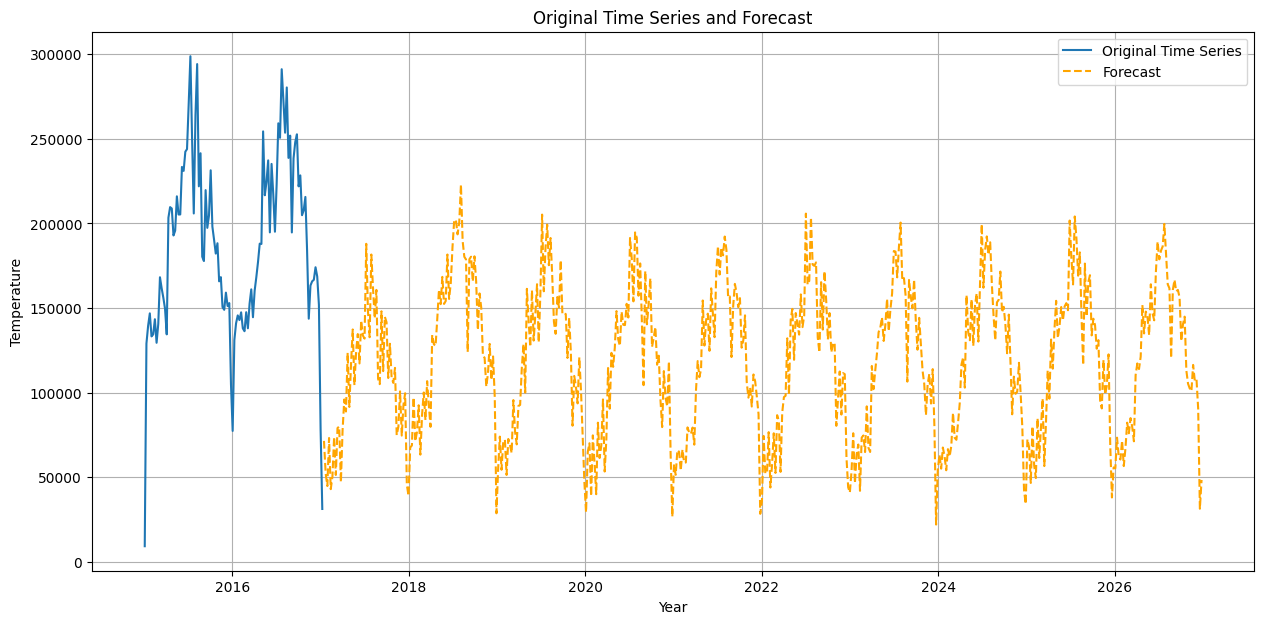

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(weekly_data.index, weekly_data['weekly_count'], label='Original Time Series')

plt.plot(forecast.index, forecast, label='Forecast', linestyle='--', color='orange')


# Customize the plot
plt.title('Original Time Series and Forecast')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Now it is capturing better the seasonality!
Still, there is room for improvement:
- UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.
